<br/>

$$ \huge{\underline{\textbf{ Artificial Neural Network }}} $$

<br/>

<center>Example implementation of <b>Artificial Neural Network</b></center>
<center>from Sutton and Barto 2018, <b>chapter 9.7</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<a href="https://github.com/marcinbogdanski/ai_sketchpad"><- index</a>
    
<br/>

Even though explicit algorithm is not presented in the book, we will apply neural network to the corridor environment defined in [chapter 9.3](0903a_Gradient_MC.html)

We are going to use Gradient MC algorithm from chapter 9.3 as a learning algorithm. Before continuing you should familiarise yourself properly with [chapter 9.3](0903a_Gradient_MC.html).

Data generated by agent in reinforcement learning setting is highly correlated, observation at time step t=1000 is probably very similar to t=1001 and so on. Neural networks are inherently unstable when trained on highly correlated data.

As an introduction to this post read [this mini post](../Mini_Posts/ANN_Correlated_Data.html). It's very short and shows exactly why correlated data is bad and how memory reply fixes it.

I am going to present performance of vanilla gradient MC as well as modified version with memory reply.

---

# Environment Setup

In [1070]:
import numpy as np
import matplotlib.pyplot as plt
from helpers_0907 import ANNFuncApprox

In [1071]:
env = LinearEnv()

In [1072]:
def policy(st):
    return np.random.choice([0, 1])

# Neural Network Function Approximator

ANNFuncApprox is a minimal implementation of ANN using only numpy. You can check the full source [here](helpers_0907.py)
* it has two layers only
  * sigmoid hidden layer
  * linear (no activation) output layer
  
Create neural net like so

In [1073]:
model = ANNFuncApprox(learn_rate=1, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)

where **x_min** and **x_max** define input range (inputs are scaled internally to 0..1) and **nb_in**, **nb_hid** and **nb_out** are number of inputs, hidden units and outputs respectively. As you can see 3 hidden neurons is not really an earth shattering model, but then value function for corridor example is a stright line, so this should be plenty enough.

Usage is quite simple as well, you can feed in one data point at a time, or in batches

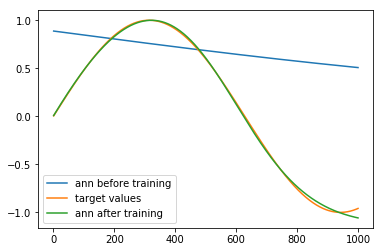

In [1074]:
x = np.linspace(start=1, stop=1000, num=1000).reshape([-1,1])
y = np.sin(x/200)

plt.plot(x, model.eval(x), label='ann before training')
plt.plot(x, y, label='target values')

for i in range(10000):
    model.train(x, y)

plt.plot(x, model.eval(x), label='ann after training')
plt.legend();

# Vanilla Gradient MC + Neural Network

This is just a standard Gradient MC as presented in [chapter 9.3](0903a_Gradient_MC.html). We will use the "fixed" version of Gradient MC, repeated here for reference.

In [483]:
def gradient_MC_vanilla(env, policy, ep, gamma, model, callback=None, trace=None):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env    - environment
        policy - function in a form: policy(state)->action
        ep     - number of episodes to run
        gamma  - discount factor [0..1]
        model  - function approximator, already initialised, with method:
                     train(state, target) -> None
        callback - function in a form: callback(episode, model, trace) -> None
        trace  - passed to callback, so it can log data into it
    """
    for e_ in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
            model.train(St, Gt)
               
        if callback is not None:
            callback(e_, model, trace)

Helper functions:

In [1016]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

### Quick test

Note that it took me a while to find hyperparameters to make it learn at all

In [ ]:
def gradient_MC_memrep(env, policy, ep, gamma, model, callback=None, trace=None):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env    - environment
        policy - function in a form: policy(state)->action
        ep     - number of episodes to run
        gamma  - discount factor [0..1]
        model  - function approximator, already initialised, with method:
                     train(state, target) -> None
        callback - function in a form: callback(episode, model, trace) -> None
        trace  - passed to callback, so it can log data into it
    """
    
    mem_states = CircularBuff(maxlen=100000, dtype=int)               # 
    mem_returns = CircularBuff(maxlen=100000, dtype=float)
    
    for e_ in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
            
            mem_states.append(St)
            mem_returns.append(Gt)
            
        idx = np.random.randint(low=0, high=len(mem_states),
                                size=min(10000,len(mem_states)))
        states = mem_states.data[idx].reshape([-1,1])     # column vector
        returns = mem_returns.data[idx].reshape([-1,1])   # column vector
        
        model.train(states, returns)
               
        if callback is not None:
            callback(e_, model, trace)

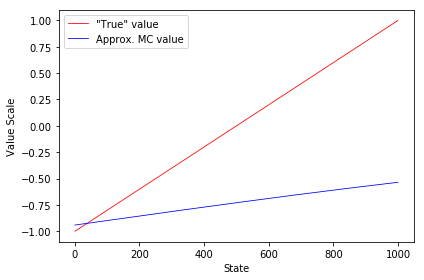

In [985]:
trace=[]
model = ANNFuncApprox(learn_rate=0.033, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
V = [model.eval(st) for st in range(1001)]
plot_linear(V, env=env)

In [993]:
gradient_MC_memrep(env, policy, ep=5000, gamma=1.0, model=model, callback=callback, trace=trace)
V = [model.eval(st) for st in range(1001)]
plot_linear(V, env=env)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


KeyboardInterrupt: 

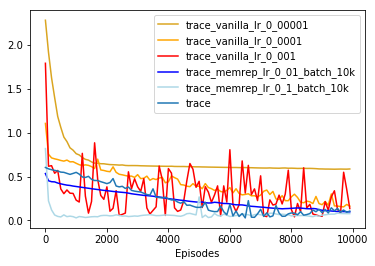

In [1015]:
fig = plt.figure()
ax = fig.add_subplot(111)
xx_temp = np.array(range(len(trace_vanilla_lr_0_001))) * 100
ax.plot(xx_temp, trace_vanilla_lr_0_00001, color='goldenrod', label='trace_vanilla_lr_0_00001')
ax.plot(xx_temp, trace_vanilla_lr_0_0001, color='orange', label='trace_vanilla_lr_0_0001')
ax.plot(xx_temp, trace_vanilla_lr_0_001, color='red', label='trace_vanilla_lr_0_001')

ax.plot(xx_temp, trace_memrep_lr_0_01_batch_10k, color='blue', label='trace_memrep_lr_0_01_batch_10k')
ax.plot(xx_temp, trace_memrep_lr_0_1_batch_10k, color='lightblue', label='trace_memrep_lr_0_1_batch_10k')
ax.plot(np.array(range(len(trace)))*100, trace, label='trace')

#ax.set_ylabel('$\sqrt{\overline{VE}}$ averaged over 10 runs')
ax.set_xlabel('Episodes')
ax.legend()
plt.show()

In [980]:
trace_memrep_lr_0_01_batch_10k = trace

In [ ]:
trace_memrep_lr_0_033_batch_10k

In [973]:
trace_memrep_lr_0_1_batch_10k

---

In [752]:
from collections import deque

In [915]:
class CircularBuff:
    def __init__(self, maxlen, dtype):
        self.maxlen = maxlen
        self.idx = 0
        self.length = 0
        self.data = np.zeros(shape=[maxlen], dtype=dtype)
    
    def append(self, item):
        self.data[self.idx] = item
        self.idx += 1
        if self.idx >= len(self.data):
            self.idx = 0
            
        if self.length < self.maxlen:
            self.length += 1
            
    def __len__(self):
        return self.length
            
    

In [912]:
len(cb)

10

In [914]:
cb = CircularBuff(maxlen=10, dtype=int)
for i in range(20):
    cb.append(i)
    print(cb.data)
    print(len(cb))
    print('--')
cb.data

[0 0 0 0 0 0 0 0 0 0]
1
--
[0 1 0 0 0 0 0 0 0 0]
2
--
[0 1 2 0 0 0 0 0 0 0]
3
--
[0 1 2 3 0 0 0 0 0 0]
4
--
[0 1 2 3 4 0 0 0 0 0]
5
--
[0 1 2 3 4 5 0 0 0 0]
6
--
[0 1 2 3 4 5 6 0 0 0]
7
--
[0 1 2 3 4 5 6 7 0 0]
8
--
[0 1 2 3 4 5 6 7 8 0]
9
--
[0 1 2 3 4 5 6 7 8 9]
10
--
[10  1  2  3  4  5  6  7  8  9]
10
--
[10 11  2  3  4  5  6  7  8  9]
10
--
[10 11 12  3  4  5  6  7  8  9]
10
--
[10 11 12 13  4  5  6  7  8  9]
10
--
[10 11 12 13 14  5  6  7  8  9]
10
--
[10 11 12 13 14 15  6  7  8  9]
10
--
[10 11 12 13 14 15 16  7  8  9]
10
--
[10 11 12 13 14 15 16 17  8  9]
10
--
[10 11 12 13 14 15 16 17 18  9]
10
--
[10 11 12 13 14 15 16 17 18 19]
10
--


array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [ ]:
xx, yy = [], []

for ep in range(1000):
    traj, T = generate_episode(env, policy)
    for i in range(len(traj)):
        xx.append(traj[i][0])
        yy.append(traj[-1][1])
    
    
plt.scatter(xx, yy)

xx = np.array(xx, ndmin=2).T
yy = np.array(yy, ndmin=2).T

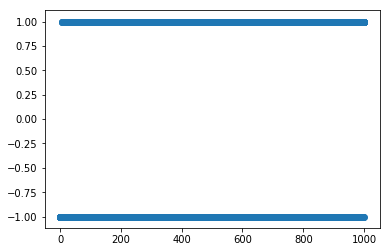

In [802]:
xx, yy = [], []

for ep in range(1000):
    traj, T = generate_episode(env, policy)
    for i in range(len(traj)):
        xx.append(traj[i][0])
        yy.append(traj[-1][1])
    
    
plt.scatter(xx, yy)

xx = np.array(xx, ndmin=2).T
yy = np.array(yy, ndmin=2).T

In [805]:
model = ANNFuncApprox(learn_rate=0.1, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)

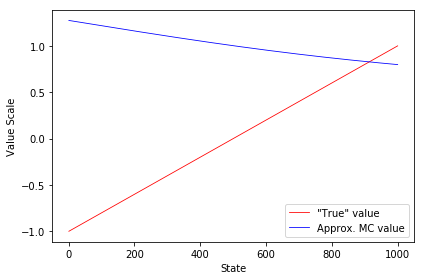

In [806]:
V = [model.eval(st) for st in range(1001)]
plot_linear(V, env=env)

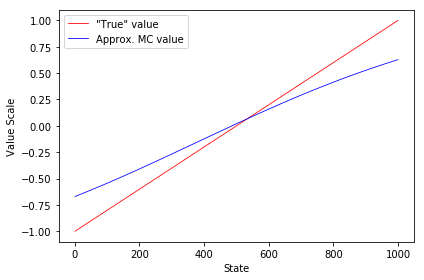

In [814]:
for i in range(100):
    indices = np.random.choice(range(len(xx)), size=1000)
    model.train(xx[indices], yy[indices])

# for i in range(10):
#     model.train(xx[0,0], yy[0,0])
#     model.train(xx[500,0], yy[500,0])
#     model.train(xx[999,0], yy[999,0])

# for i in range(1000):
#     k = np.random.randint(0, len(xx))
#     model.train(xx[k,0], yy[k,0])

# gradient_MC(env, policy, ep=1, gamma=1.0, model=model)
V = [model.eval(st) for st in range(1001)]
plot_linear(V, env=env)

In [815]:
print(model.total_train_samples)

700000


---

# Environment Setup

All environment and plotting code is exactly the same as in [chapter 9.3](0903a_Gradient_MC.ipynb). All the code is available here: [helpers_0905.py](helpers_0905.py)

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from helpers_0905 import LinearEnv, plot_linear

In [4]:
env = LinearEnv()

In [5]:
def policy(st):
    return np.random.choice([0, 1])

# Artificial Neural Network

Minimal implementation of ANN using only numpy. Nothing new here, you can skip this section.
* two layers only
  * sigmoid hidden layer
  * linear (no activation) output layer

In [795]:
class ANNFuncApprox():
    """Minimal ANN implementation
    
    Layers:
        * 1x hidden sigmoid layer
        * 1x linear output layer
    """
    def __init__(self, learn_rate, x_min, x_max, nb_in, nb_hid, nb_out):
        """
        Params:
            learn_rate - learn rate for backprop
            x_min      - minimum values for inputs - for scaling
            x_max      - maximum values for inputs - for scaling
            nb_in      - number of inputs
            nb_hid     - number of hidden neurons
            nb_outt    - number of outputs
        """
        self._lr = learn_rate
        self._x_min = x_min
        self._x_max = x_max
        
        self._Wh = np.random.normal(loc=0, scale=1/nb_in**-.5, size=[nb_in, nb_hid])   # Xavier
        self._bh = np.zeros(shape=[1, nb_hid])
        self._Wo = np.random.normal(loc=0, scale=1/nb_hid**-.5, size=[nb_hid, nb_out])
        self._bo = np.zeros(shape=[1, nb_out])
        
        self.total_train_samples = 0
        
    def eval(self, x):
        """Forward pass on neural network
        
        Params:
            x - input, either scalar or 2d np.ndarray with dims: [batch_size, num_inputs]
        """
        if np.isscalar(x):   x = np.array([[x]])             # needed so @ operator works ok
        assert x.ndim == 2                                   # tested for 2d numpy arrays only
        
        x = (x - self._x_min) / (self._x_max - self._x_min)  # scale input to range [0..1]
        
        z_hid = x @ self._Wh + self._bh                      # input to hidden layer
        h_hid = self.sigmoid(z_hid)                          # output from hidden layer
        z_out = h_hid @ self._Wo + self._bo                  # input to output layer
        y_hat = z_out                                        # output (linear activation)
        
        return float(y_hat)

        
    def train(self, x, y):
        """Perform batch update using backprop
        
        Params:
            x - input, either scalar or 2d np.ndarray with dims: [batch_size, num_inputs]
            y - target, either scalar or 2d np.ndarray with dims: [batch_size, num_outputs]
        """
        if np.isscalar(x):   x = np.array([[x]])             # needed so @ operator works ok
        if np.isscalar(y):   y = np.array([[y]])
        
        self.total_train_samples += len(x)
        
        x = (x - self._x_min) / (self._x_max - self._x_min)  # scale to range [0..1]
        
        # Forward pass
        z_hid = x @ self._Wh + self._bh                      # input to hidden layer
        h_hid = self.sigmoid(z_hid)                          # output from hidden layer
        z_out = h_hid @ self._Wo + self._bo                  # input to output layer
        y_hat = z_out                                        # output (linear activation)
        
        # Backward pass
        ro_o = -1 * (y - y_hat)                              # error term output layer (linear)
        dWo = h_hid.T @ ro_o                      / len(x)   # delta weights output
        dbo = np.sum(ro_o, axis=0, keepdims=True) / len(x)   # delta biases output
        ro_h = ro_o @ self._Wo.T * self.sigmoid_deriv(z_hid) # error term hidden layer
        dWh = x.T @ ro_h                          / len(x)   # delta weights hidden
        dbh = np.sum(ro_h, axis=0, keepdims=True) / len(x)   # delta biases hidden
        
        # Update weights
        self._Wh += -self._lr * dWh
        self._bh += -self._lr * dbh
        self._Wo += -self._lr * dWo
        self._bo += -self._lr * dbo
        
        return dWh, dbh, dWo, dbo       # so we can do numerical gradient check
            
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def sigmoid_deriv(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

In [863]:
def callback(episode, model, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    if episode % 100 != 0:    return
    V = np.array([model.eval(st) for st in range(1001)])                   # arr of float
    err = np.sqrt(np.mean(np.power((np.array(V[1:]) - env.V_approx[1:]), 2)))  # float
    trace.append(err)
    print(episode)

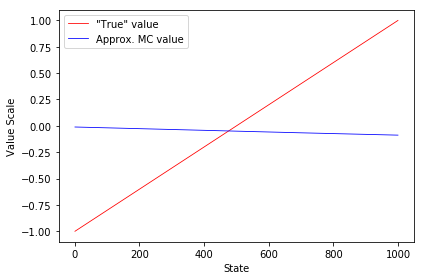

In [1010]:
trace=[]
model = ANNFuncApprox(learn_rate=0.01, x_min=1, x_max=1000, nb_in=1, nb_hid=3, nb_out=1)
V = [model.eval(st) for st in range(1001)]
plot_linear(V, env=env)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


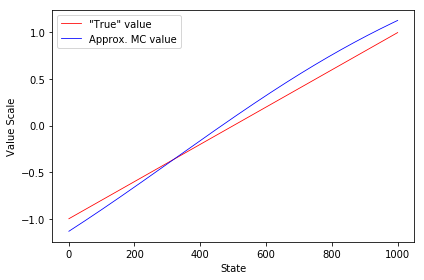

In [1013]:
gradient_MC_normal_2(env, policy, ep=5000, gamma=1.0, model=model, callback=callback, trace=trace)
V = [model.eval(st) for st in range(1001)]
plot_linear(V, env=env)

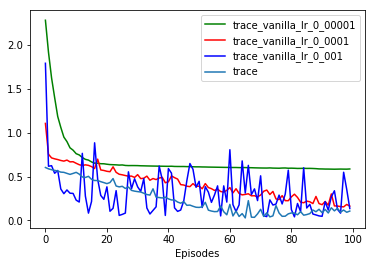

In [1014]:
fig = plt.figure()
ax = fig.add_subplot(111)
xx_temp = np.array(range(len(trace))) * 100
ax.plot(trace_vanilla_lr_0_00001, color='green', label='trace_vanilla_lr_0_00001')
ax.plot(trace_vanilla_lr_0_0001, color='red', label='trace_vanilla_lr_0_0001')
ax.plot(trace_vanilla_lr_0_001, color='blue', label='trace_vanilla_lr_0_001')
ax.plot(trace, label='trace')

#ax.set_ylabel('$\sqrt{\overline{VE}}$ averaged over 10 runs')
ax.set_xlabel('Episodes')
ax.legend()
plt.show()

In [876]:
trace_vanilla_lr_0_00001

In [861]:
trace_vanilla_lr_0_0001

In [868]:
trace_vanilla_lr_0_001

In [820]:
model.total_train_samples

85202

In [33]:
np.random.shuffle(np.array(range(T-1, -1, -1)))

Quick test #2: now with **four** sets of tiles, each offset by 1/4 of tile width. Note that small 'steps' are not completly independent, tiles still have same width as before.

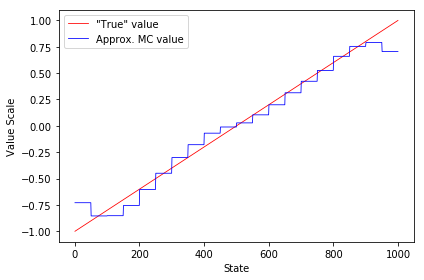

In [17]:
model = TileCodingFuncApprox(learn_rate=0.001, tile_size=200, nb_tilings=4, nb_states=1001)
gradient_MC(env, policy, ep=1000, gamma=1.0, model=model)
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env=env)

# Reproduce Figure 9.10

Callback is called by *gradient_MC* every single timestep:
* only process every 100th episode (speed)
* compute V for all states
* compute Root Mean Squared Error (skip terminal state 0, state 1001 is out of boundry)
* append to *rmse* list

In [18]:
def callback(episode, model, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    if episode % 100 != 0:    return
    V = np.array([model.evaluate(st) for st in range(1001)])                   # arr of float
    err = np.sqrt(np.mean(np.power((np.array(V[1:]) - env.V_approx[1:]), 2)))  # float
    trace.append(err)

Define experiment

In [19]:
def experiment(runs, env, policy, ep, gamma, model, callback):
    results = []  # dims: [nb_runs, nb_episodes]
    for r in range(runs):
        trace = []  # dim: [nb_episodes]
        model.reset()
        gradient_MC(env, policy, ep, gamma, model, callback=callback, trace=trace)
        results.append(trace)
    return np.average(results, axis=0)

Compute result for tilings=1. Average over 10 runs. This took ~6min.

In [276]:
ts = time.time()
model_1 = TileCodingFuncApprox(learn_rate=0.0001, tile_size=200, nb_tilings=1, nb_states=1001)
tiles_1 = experiment(10, env, policy, ep=10000, gamma=1.0, model=model_1, callback=callback)
print('Time took:', time.time()-ts)

Time took: 363.76061820983887


And for tilings=50. Note that alpha is automatically divided by nb_tilings, so we are still in line with the book.

In [280]:
ts = time.time()
model_50 = TileCodingFuncApprox(learn_rate=0.0001, tile_size=200, nb_tilings=50, nb_states=1001)
tiles_50 = experiment(10, env, policy, ep=10000, gamma=1.0, model=model_50, callback=callback)
print('Time took:', time.time()-ts)

Time took: 979.4627282619476


Plot results

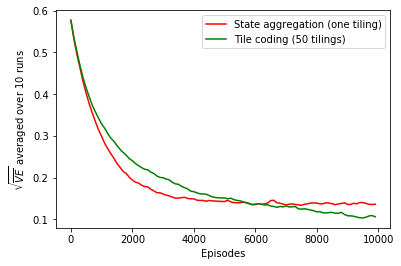

In [305]:
fig = plt.figure()
ax = fig.add_subplot(111)
xx = np.array(range(len(tiles_1))) * 100
ax.plot(xx, tiles_1, color='red', label='State aggregation (one tiling)')
ax.plot(xx, tiles_50, color='green', label='Tile coding (50 tilings)')
ax.set_ylabel('$\sqrt{\overline{VE}}$ averaged over 10 runs')
ax.set_xlabel('Episodes')
# plt.savefig('assets/fig_0910.png')
ax.legend()
plt.show()

And plot final values for V

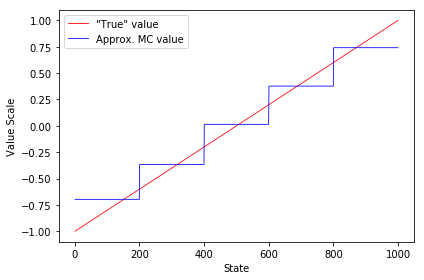

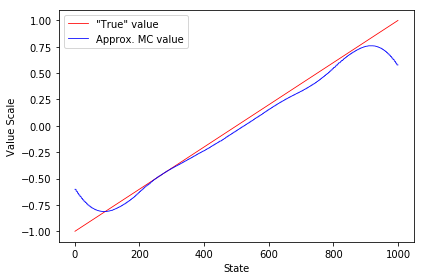

In [25]:
V_1 = [model_1.evaluate(st) for st in range(1001)]
V_50 = [model_50.evaluate(st) for st in range(1001)]

plot_linear(V_1, env)
plot_linear(V_50, env)